# Using CNN (Convolutional Neural Network) to Classify Images of Big Cats
Prepared By: Kiana Villaera

Much of the other content in this notebook [references this notebook](https://www.kaggle.com/code/misski/big-cats-classification-acc/edit).

## Problem Statement

There are many state-of-the-art architectures out there like:
* **ResNet** a popular architecture that uses residual connections to enable training of very deep networks.
* **Inception** uses multiple parallel convolutions at different scales to capture fine-grained details in images.
* **Xception** a variant of Inception, uses depthwise separable convolutions to reduce computational complexity while maintaining accuracy.
* **MobileNet** is another efficient architecture that is designed for mobile and embedded devices.
* **EfficientNet** is a recent architecture that achieves state-of-the-art performance by automatically scaling up the network's depth, width, and resolution.

However, in this notebook, we want to come up with our own model architecture that can beat a baseline model. We can just use **transfer learning** and pick up a SOTA model and fine-tune it as seen in the reference notebook. The exact parameter for this notebook is to come up with a relatively light-weight yet well-performing image classification model.

### PCC

We will use 1.25PCC as a baseline for model performance.

## Preliminaries

In this section we go through the fundamental knowledge needed to understand how CNN and neural networks in general work. This might be an eyeful but it's necessary for those of us who are only starting out in deep learning.

### What are deep neural networks?
A deep neural network is a type of machine learning model, and when it is fitted to data, this is referred to as deep learning.[[1]](https://udlbook.github.io/udlbook/) We are primarily interested in the weights that result from model training. That's what model checkpoints with a .h5 extension refer to.

![images/ai_ml_dl.PNG](images/ai_ml_dl.PNG)

**Figure 1: AI/ML/DL body of knowledge**

Deep neural networks can process inputs that are very large, of variable length, and contain various kinds of internal structures. They can output single real numbers (regression), multuple numbers (multivariate regression) or probabilities over two or more classes (binary and multiclass classification)[[1]](https://udlbook.github.io/udlbook/). 

![images/dnn_highlevel.PNG](images/dnn_highlevel.PNG)

**Figure 2: High level overview of DNN**

### The Basic Idea Behind Neural Networks

![images/nn_playground.PNG](images/nn_playground.PNG)

**Figure 3: Visualization of a Simple Classifier Taken From [Tensorflow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=20&dataset=xor&regDataset=reg-plane&learningRate=0.1&regularizationRate=0.1&noise=0&networkShape=4,4&seed=0.91964&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)**

The basic idea is that you have an $X$ amount of features, which you then feed to an $N$ amount of hidden layers wherein each layer contains an $n$ number of neurons. Each neuron takes in multiple inputs from the previous layer and calculates a value given weights $w$ and biases $b$, and that output is fed to each neuron in the next hidden layer. After all the hidden layers have been gone through, you get an output based on all the computed weights. In the case of image classification, whatever output you get from the last layer will tell you what class the image belongs to. That output is computed through the hidden layers.

There are many other elements to a neural network, such as the use of activation functions, regluarization, learning rate tuning, and more.

#### Terminology

* Any neural network with at least one hidden layer is called a **multi-layer perceptron**.
* Networks with only one hidden layer are termed **shallow neural networks**.
* Networks with multiple hidden layers are referred to as **deep neural networks**.
* Neural networks in which the connections form an acyclic graph are referred to as **feed-forward networks**.
* If every element in one layer connects to every element in the next, the network is said to be **fully connected**.

### Activation Functions

An activation function in a neural network is a function that decides based on the output of the previous neuron, what output to be sent to the next neuron. So in a sense it decides whether to "activate" a neuron or not. They impose a range to the values being fed to the neurons. There are several different types of activation functions, but ReLU is one of the most common ones. The equation is given below:

$$
ReLU(x)=
\begin{cases}
    0 & \text{if } x < 0 \\
    x & \text{if } x \geq 0
\end{cases}
$$

This means that we return the input if it's positive, otherwise we return 0. Activation functions are important because since it imposes a range of the inputs to the neurons. Depending on the problem, we want to limit the range of our values to avoid computational issues. Additionally, they add non-linearity. Without activation functions, the neural network is nothing more than a stacked linear regression model that cannot learn complex patterns. After each layer, we apply an activation function that applies a nonlinear transformation. Please see [dying ReLU problem](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks).

Other popular activation functions include:
* Step function
* Sigmoid
* TanH
* Leaky ReLU
* Softmax

When we pass the data through the network, the values of the inputs to the hidden layer are termed **pre-activations**. The values at the hidden layer are termed **activations**[[1]](https://udlbook.github.io/udlbook/)

### Loss Functions

A loss function returns a single number that describes the mismatch between the model predictions and their corresponding ground-truth outputs. During training, we seek parameter values that minimize the loss and hence map the training inputs to the outputs as closely as possible.

In Tensorflow, we have the following possible loss functions:

#### Probabilistic Loss Functions
* Binary Cross-Entropy Loss - typical for binary classication
* Categorical Cross-Entropy Loss - typical for multiclass classification problems
* Sparse Categorical Crossentropy Loss - when the input labels are not integers
* Poisson Loss
* Kullback-Leibler Divergence Loss


### Illustration of how computations are done in DNN

![images/dnn_computation.PNG](images/dnn_computation.PNG)

**Figure 4: Illustration of how DNN computes values through layers**

### Regularization

Regularization is...

### What is a [Convolutional Neural Network (CNN)](https://poloclub.github.io/cnn-explainer/)?
Images have 3 properties that suggest they require a specialized model architecture.
1. Images are highly dimensional. If the images are 224 x 224, then that means there are over 150,528 input dimensions. The amount of weights will explode.
2. Nearby image pixels are statistically related, but fully connected networks have no notion of "distance"
3. Image interpretations are stable under geometric transformations

Convolutional layers process each local image region independently, using parameters that are shared across the whole image. 


### Other Terminology
* A **tensor** can be thought of as an n-dimensional matrix. In the CNN above, tensors will be 3-dimensional with the exception of the output layer.

### Hyperparameters
We will find the best hyperparameters using Tensorflow's `randomsearch`
* learning rate - reduce this for a smoother learning curve
* epoch - essentially how many passes
* batch size - increase this to allow the model to see more samples per iteration
* n_layers - how many layers
* units per layer - how many neurons in each hidden layer
* dropout rate - to prevent problems

## Evaluating Model Performance
* Accuracy
* Loss

In [1]:
# Common imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List
from glob import glob

# Data Imports
import pandas as pd
from tqdm import tqdm
from tensorflow import image as tfi

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

# Model Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras import layers, models

# Model Training
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Model Hypertunning
!pip install -q keras_tuner
cls()
import keras_tuner as kt

# utility functions
from utilities import load_dataset
from utilities import show_images
from utilities import plot_class_distribution

In [2]:
# Set the directories for the dataset
train_dir = 'data/train/'
test_dir = 'data/test/'
valid_dir = 'data/valid/'

# Get all class names and count the number of classes
class_names = os.listdir(train_dir)
n_classes = len(class_names)

# Set some constants for the dataset
BATCH_SIZE = 32 # Number of samples in each batch during training
IMG_SIZE = 224 # Size of the image
AUTOTUNE = tf.data.AUTOTUNE # Set to optimize the buffer size automatically
LEARNING_RATE = 1e-3 # Learning rate for the optimizer used during model training

# Set the random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
# create model_checkpoints directory
if not os.path.isdir("model_checkpoints"):
    os.mkdir("model_checkpoints")

# Load the datasets
X_train, y_train, class_names = load_dataset(IMG_SIZE = IMG_SIZE, root_path = train_dir, class_names = class_names)
X_valid, y_valid, class_names = load_dataset(IMG_SIZE = IMG_SIZE, root_path = valid_dir, class_names = class_names)
X_test, y_test, class_names = load_dataset(IMG_SIZE = IMG_SIZE, root_path = test_dir, class_names = class_names)

Loading:  10%|█         | 1/10 [00:00<00:02,  3.16it/s]

Loading: 100%|██████████| 10/10 [00:00<00:00, 175.03it/s]


## Look at sample images

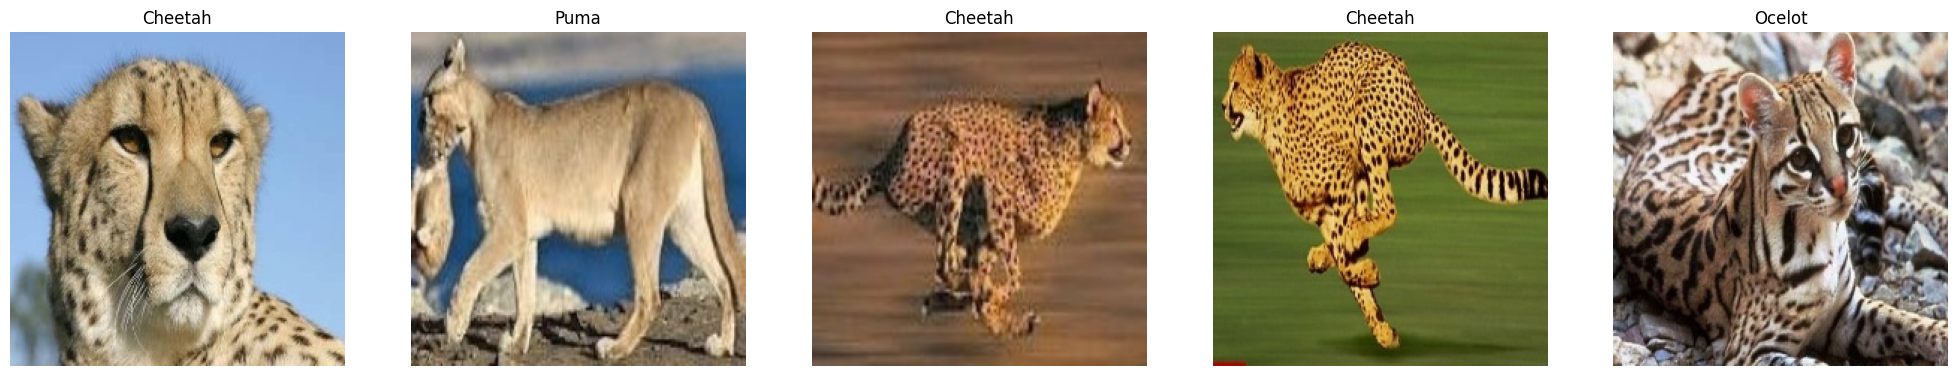

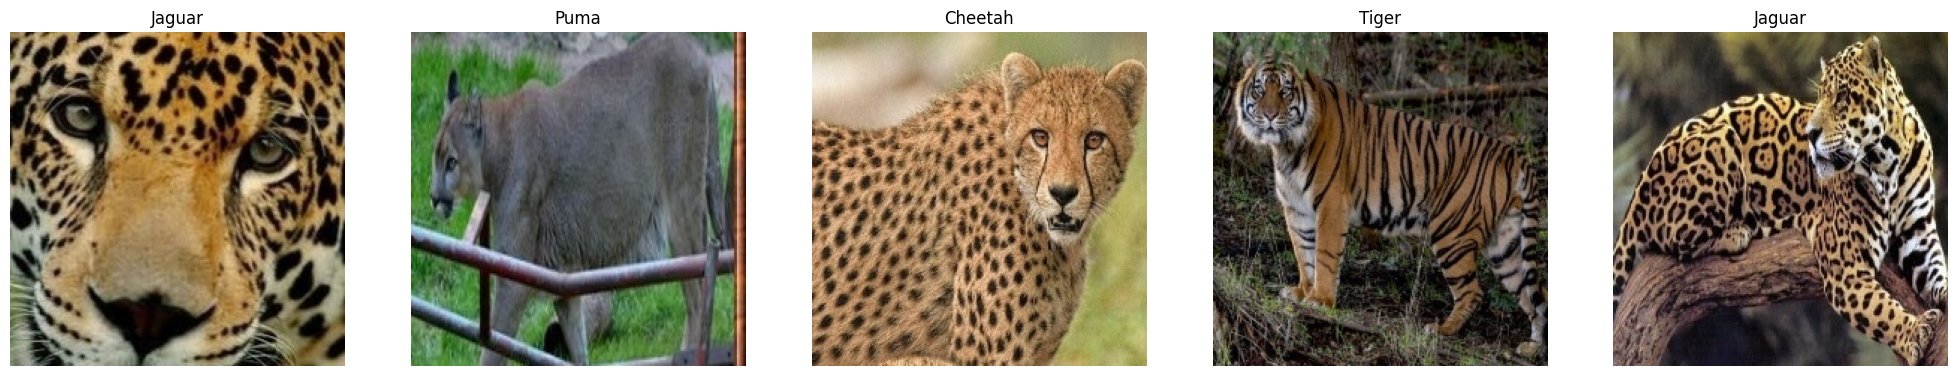

In [4]:
show_images(class_names, images=X_train, labels=y_train, n_rows=2)

## Class Distribution

Check class distribution for training set, test set, and validation set.

Conveniently, the class distribution looks to be nearly equal across all sets.

In [5]:
plot_class_distribution(train_dir, class_names, "Training Set")
plot_class_distribution(test_dir, class_names, "Test Set")
plot_class_distribution(valid_dir, class_names, "Validation Set")

## [The Barest Model Possible](https://www.tensorflow.org/tutorials/images/cnn)

This is the most basic implementation of CNN on the dataset.

### Load or Train the Model

If you've already trained the model before, just load it. Otherwise, train it again.

Epoch 1/20
74/74 [==============================] - 41s 538ms/step - loss: 12.3380 - accuracy: 0.0971 - val_loss: 12.3813 - val_accuracy: 0.1000
Epoch 2/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



74/74 [==============================] - 34s 465ms/step - loss: 12.3930 - accuracy: 0.0979 - val_loss: 12.3813 - val_accuracy: 0.1000
Epoch 3/20
74/74 [==============================] - 35s 469ms/step - loss: 12.3930 - accuracy: 0.0979 - val_loss: 12.3813 - val_accuracy: 0.1000
Epoch 4/20
74/74 [==============================] - 34s 456ms/step - loss: 12.3930 - accuracy: 0.0979 - val_loss: 12.3813 - val_accuracy: 0.1000


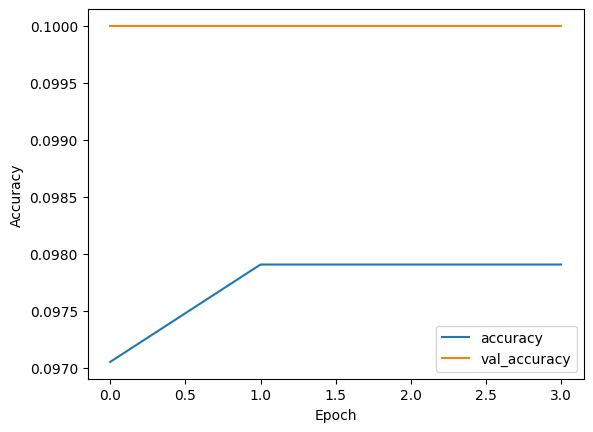

2/2 - 0s - loss: 12.3813 - accuracy: 0.1000 - 215ms/epoch - 108ms/step
test_loss: 12.381278038024902
test_accuracy: 0.10000000149011612


In [6]:
train_new = True

def plot_history(history):
    plt.plot(history['accuracy'], label='accuracy')
    plt.plot(history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

if not os.path.isfile("model_checkpoints/Baseline.h5") or train_new:
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics='accuracy'
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=10,
        validation_split=0.2,
        batch_size=BATCH_SIZE,
        callbacks=[
            EarlyStopping(patience=3, restore_best_weights=True),
            ModelCheckpoint("model_checkpoints/Baseline.h5", save_best_only=True)
        ]
    )

    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv('histories/baseline.csv')
    model.save("model_checkpoints/Baseline.h5")

    plot_history(history.history)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f"test_loss: {test_loss}")
    print(f"test_accuracy: {test_acc}")
else:
    model = keras.models.load_model('model_checkpoints/Baseline.h5', compile=True)
    history = pd.read_csv('histories/baseline.csv')
    plot_history(history)

## Vanilla with extra steps

Increase some parameters and see what happens

Epoch 1/10
74/74 [==============================] - 224s 3s/step - loss: 12.1214 - accuracy: 0.1543 - val_loss: 2.0844 - val_accuracy: 0.3200
Epoch 2/10
74/74 [==============================] - 227s 3s/step - loss: 1.7266 - accuracy: 0.3749 - val_loss: 1.7790 - val_accuracy: 0.3000
Epoch 3/10
74/74 [==============================] - 201s 3s/step - loss: 0.7926 - accuracy: 0.7443 - val_loss: 2.2711 - val_accuracy: 0.2600
Epoch 4/10
74/74 [==============================] - 231s 3s/step - loss: 0.2476 - accuracy: 0.9299 - val_loss: 1.6536 - val_accuracy: 0.4600
Epoch 5/10
74/74 [==============================] - 280s 4s/step - loss: 0.0526 - accuracy: 0.9927 - val_loss: 1.7714 - val_accuracy: 0.4400
Epoch 6/10
74/74 [==============================] - 267s 4s/step - loss: 0.0132 - accuracy: 0.9983 - val_loss: 2.1375 - val_accuracy: 0.4200
Epoch 7/10
74/74 [==============================] - 269s 4s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.7422 - val_accuracy: 0.5200


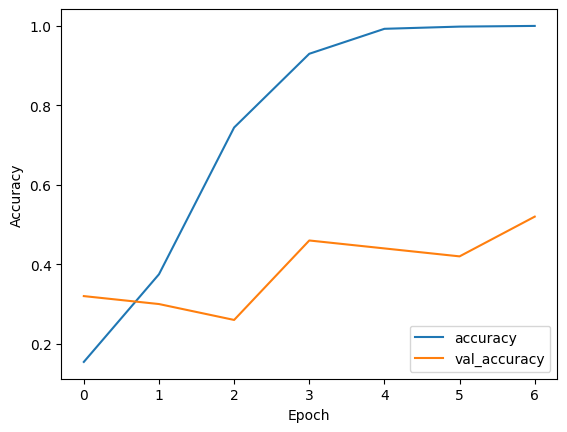

2/2 - 1s - loss: 1.7549 - accuracy: 0.3600 - 547ms/epoch - 273ms/step
test_loss: 1.7549338340759277
test_accuracy: 0.36000001430511475


In [24]:
train_new = True

def plot_history(history):
    plt.plot(history['accuracy'], label='accuracy')
    plt.plot(history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

if not os.path.isfile("model_checkpoints/Baseline.h5") or train_new:
    model = Sequential()
    # convolutional layer
    model.add(layers.Conv2D(
        25, kernel_size=(3,3), strides=(1,1), padding='valid',
        activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
    model.add(layers.MaxPool2D(pool_size=(1,1)))
    # flatten output of conv
    model.add(layers.Flatten())
    # hidden layer
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    # output layer
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics='accuracy'
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=10,
        validation_split=0.2,
        batch_size=BATCH_SIZE,
        callbacks=[
            EarlyStopping(patience=3, restore_best_weights=True),
            ModelCheckpoint("model_checkpoints/BaselineExtra.h5", save_best_only=True)
        ]
    )

    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv('histories/baseline_extra.csv')
    model.save("model_checkpoints/BaselineExtra.h5")

    plot_history(history.history)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f"test_loss: {test_loss}")
    print(f"test_accuracy: {test_acc}")
else:
    model = keras.models.load_model('model_checkpoints/BaselineExtra.h5', compile=True)
    history = pd.read_csv('histories/baseline_extra.csv')
    plot_history(history)

We added 3 more hidden layers with 200 units each. The accuracy has vastly improved compared to the extremely vanilla model. This goes to show how adding more hidden layers can actually improve model performance.

## Training a baseline model with MobileNetV2 as the backbone

Train a basic model with MobileNetV2 as the backbone.

Epoch 1/20
74/74 [==============================] - 135s 2s/step - loss: 0.7692 - accuracy: 0.7431 - val_loss: 11.3789 - val_accuracy: 0.1600
Epoch 2/20
74/74 [==============================] - 128s 2s/step - loss: 0.3324 - accuracy: 0.8965 - val_loss: 11.1037 - val_accuracy: 0.2400
Epoch 3/20
74/74 [==============================] - 127s 2s/step - loss: 0.3725 - accuracy: 0.8837 - val_loss: 16.4630 - val_accuracy: 0.2400
Epoch 4/20
74/74 [==============================] - 134s 2s/step - loss: 0.2849 - accuracy: 0.9124 - val_loss: 11.8209 - val_accuracy: 0.4200
Epoch 5/20
74/74 [==============================] - 132s 2s/step - loss: 0.1527 - accuracy: 0.9500 - val_loss: 22.5972 - val_accuracy: 0.1000


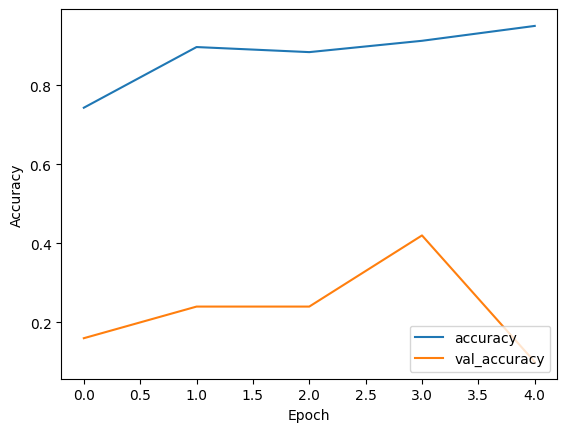

2/2 [==============================] - 0s 120ms/step - loss: 11.6646 - accuracy: 0.2200
MobileNetV2 Baseline Testing Loss     : 11.664569854736328.
MobileNetV2 Baseline Testing Accuracy : 0.2199999988079071.


In [25]:
# baseline MobileNetV2
train_new = True

if not os.path.isfile("model_checkpoints/MobileNetBaseline.h5") or train_new:
    # Create the simplest model architecture using the current backbone.
    baseline_mobilenet = Sequential([
        MobileNetV2(input_shape=(
            IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False),
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    
    # Compile the model with the specified loss function, optimizer, and metrics.
    baseline_mobilenet.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics='accuracy'
    )
    
    # Train the model on a subset of the training data.
    history = baseline_mobilenet.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=20,
        validation_split=0.2,
        batch_size=BATCH_SIZE,
        callbacks=[
            EarlyStopping(patience=3, restore_best_weights=True),
            ModelCheckpoint("model_checkpoints/BaselineMobileNetV2.h5", save_best_only=True)
        ]
    )

    baseline_mobilenet.save("model_checkpoints/BaselineMobileNetV2.h5")
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv('histories/baseline_mobilenet.csv')

    plot_history(history.history)

    test_loss, test_acc = baseline_mobilenet.evaluate(X_test, y_test)
    print(f"MobileNetV2 Baseline Testing Loss     : {test_loss}.")
    print(f"MobileNetV2 Baseline Testing Accuracy : {test_acc}.")
else:
    baseline_mobilenet = keras.models.load_model(
        'model_checkpoints/MobileNetBaseline.h5', compile=True)
    history = pd.read_csv('histories/baseline_mobilenet.csv')
    plot_history(history)

So much better than BaselineExtra!

## Search for the best hyperparameters

Use randomsearch

In [9]:
# Initialize Random Searcher
random_searcher = kt.RandomSearch(
    hypermodel=build_model, 
    objective='val_loss', 
    max_trials=10, 
    seed=42, 
    project_name="model_checkpoints/XceptionSearch", 
    loss='sparse_categorical_crossentropy')

# Start Searching
search = random_searcher.search(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs = 10,
    batch_size = BATCH_SIZE
)

NameError: name 'build_model' is not defined

## Create the best possible model using the best hyperparameters

In [ ]:
# Collect the best model Xception Model Architecture obtained by Random Searcher
best_xception = build_model(random_searcher.get_best_hyperparameters(num_trials=1)[0])

# Model Architecture
best_xception.summary()

# Compile Model
best_xception.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(LEARNING_RATE*0.1),
    metrics=['accuracy']
)

# Model Training
best_xception_history = best_xception.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs = 50,
    batch_size = BATCH_SIZE*2,
    callbacks = [
        EarlyStopping(patience=2, restore_best_weights=True),
        ModelCheckpoint("BestXception.h5", save_best_only=True)
    ]
)

## Get predictions

# References
[Prince, S. J. D. (2023). Understanding Deep Learning. MIT Press.](https://udlbook.github.io/udlbook/)